*Problem Defined*

Across the U.S., former oil/gas wells have become abandoned due to oil companies optimizing their contractual agreements with their respective property lenders. The ultimate concern for property lenders, after the contractual agreement is met, is how can the land restore its value? And what does that value now look like, environmentally (projected megawatts and solar energy generation) and economically (land value and long-term cost savings for property lenders)? The key question I am attempting to answer is: How can predictive models use spatial, environmental, and economic datasets to estimate post-restoration land value (in dollars per acre) for abandoned oil well sites? This analysis will aim to face the challenge of land marketability in the solar energy sector for these abandoned wells.

*Population*

This study will analyze documented states with significant quantities of unplugged oil/gas wells, such as Texas, Pennsylvania, and Oklahoma. These states host abandoned oil wells that could be optimized for solar farm installation.

*Variable Classifications*

The independent variables for this study include geospatial coordinates (latitude and longitude), well type (oil/gas), estimated solar irradiance (ALLSKY_SFC_SW_DWN), average air temperature (T2M), wind speed 2m/s (WS2M) relative humidity (RH2M).

The dependent variable for this study includes Farmland_Value_USD_per_Acre.

A confounding variable is an extraneous factor that may affect the relationship between the dependent and independent variables. The confounding variables for this study include ‘State’ and ‘Status’.

*Hypothesis*

If higher solar irradiance, temperature, wind speed, humidity, and well type are significant predictors of land value, then abandoned oil/gas well sites located in such conditions should have higher projected post-restoration land values (USD per acre) compared to sites with lower irradiance and less favorable conditions.

*Detailed Plan*

A combination of U.S. Geological Survey (USGS), NASA POWER and USDA Land Survey Data will be utilized to create an optimized dataset for this case study. Ensuring proper representation of the population is important. To do so, multiple states will be chosen in a stratified manner.  To collect the data, manual and automated retrieval procedures will be conducted.

*Dataset*

The dataset created is a robust representation of the connection between renewable energy potential and land value economics. By focusing on abandoned oil/gas well sites, I can explore how solar farm installation could repurpose land that currently holds little or no agricultural value due to contamination. Blending all of my interests (spatial analysis, environmental science, and economic forecasting) into one dataset provides an opportunity to model an industry relevant issue while satisfying my academic curiosities.

USGS well records are responsible for coordinates (latitude and longitude) and well type (oil/gas) variables, respectively. NASA POWER is responsible for estimated solar irradiance (ALLSKY_SFC_SW_DWN), average air temperature (T2M), wind speed 2m/s (WS2M) and relative humidity (RH2M) variables, respectively. USDA Land Survey Data are responsible for Farmland_Value_USD_per_Acre, State and Status variables, respectively. Both USGS and NASA POWER data were collected via web scraping methods. While USDA Land Survey Data was collected manually. This dataset ranges from 1974-2022.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import ElasticNet


# -----------------------
# Mounting and printing the dataset
# -----------------------
df = pd.read_csv(r"C:\Users\bzwil\OneDrive\Desktop\ABWELLS\data\wells_full_dataset_cleaned(1).csv")
print(df.head())
print(df.info())

# -----------------------
# Exporting the head of the dataset
# -----------------------
def export_df_head_to_image(df, filename='dataset_head.png', n_rows=10):
    table_data = df.head(n_rows)
    n_cols = len(table_data.columns)
    
    fig_width = max(16, n_cols * 1.8)  
    fig_height = max(5, n_rows * 0.6 + 1.5)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=table_data.values,
                     colLabels=table_data.columns,
                     cellLoc='center',
                     loc='center',
                     colLoc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(9.5)
    
    table.scale(1.2, 2.0)  
    
    for (i, j), cell in table.get_celld().items():
        cell.set_height(0.12)
        
        if i == 0: 
            cell.set_facecolor('#20603D')  
            cell.set_text_props(weight='bold', color='white', wrap=True)
        else:
            cell.set_text_props(wrap=True)
            
        if cell.get_text().get_text() and len(cell.get_text().get_text()) > 20:
            cell.set_fontsize(8.5)

    table.auto_set_column_width(col=list(range(n_cols)))
    
    plt.savefig(filename, bbox_inches='tight', dpi=250, facecolor='white', edgecolor='none')
    plt.close(fig)
    print(f"Clean, readable table exported to '{filename}'")
    
export_df_head_to_image(df, 'dataset_head.png', n_rows=10)

      Well identifier     County Type Status   Latitude  Longitude    State  \
0  API:01023198330000    Choctaw  OIL     AB  31.870633 -88.262407  ALABAMA   
1  API:01023199710000    Choctaw  OIL     AB  31.868743 -88.243366  ALABAMA   
2  API:01023199850000    Choctaw  OIL     AB  31.882103 -88.423896  ALABAMA   
3  API:01039200300000  Covington  OIL     AB  31.179635 -86.592117  ALABAMA   
4  API:01039200310000  Covington  OIL     AB  31.179795 -86.589197  ALABAMA   

   ALLSKY_SFC_SW_DWN        T2M      WS2M       RH2M  \
0          17.282548  17.353699  0.186712  75.960329   
1          17.282548  17.353699  0.186712  75.960329   
2          17.282548  17.353699  0.186712  75.960329   
3          17.282548  17.353699  0.186712  75.960329   
4          17.282548  17.353699  0.186712  75.960329   

   Farmland_Value_USD_per_Acre  Land_Value_Year  Status_Year  \
0                       4040.0           2022.0       1974.0   
1                       4040.0           2022.0       1974.0

##*Preliminary Information*

This dataset has 117,678 rows x 15 columns

The Variables (and unique count) include:
'Well identifier'- 117,669

'County' - 898

'Status' - 43

'Type' - 118

'Latitude' - 106,949

'Longitude' - 106937

'State' - 27

'ALLSKY_SFC_SW_DWN — (solar irradiance)' - 27

'T2M — (mean temperature at 2 meters)' - 27

'WS2M — (wind speed at 2 meters)' - 27

'RH2M — (relative humidity at 2 meters)' - 27

'Farmland_Value_USD_per_Acre' - 25

'Land_Value_Year' - 1

'Status_Year' - 5

'Historical_Farmland_Value_USD_per_Acre' - 29

Objects (strings) and float64 variables are the only data types within this dataset. The object variables include 'Well Identifier', 'County', 'Type', 'Status' and 'State'. The float64 variables include 'Latitude', 'Longitude', 'ALLSKY_SFC_SW_DWN', 'T2M', 'WS2M', 'RH2M', 'Farmland_Value_USD_per_Acre', 'Land_Value_Year', 'Status_Year' and 'Historical_Farmland_Value_USD_per_Acre'.


In [10]:
# -----------------------
# Descriptive statistics on the dataset below
# -----------------------
print("Descriptive Statistics - Abandoned Wells Dataset")
print(df.describe().T, "\n")

Descriptive Statistics - Abandoned Wells Dataset
                                           count         mean          std  \
Latitude                                117678.0    38.454632     3.271508   
Longitude                               117678.0   -88.426798     9.302877   
ALLSKY_SFC_SW_DWN                       117323.0    15.706755     1.793506   
T2M                                     117323.0    12.396468     3.596987   
WS2M                                    117323.0     1.865921     1.254115   
RH2M                                    117323.0    70.627706    10.309787   
Farmland_Value_USD_per_Acre             117248.0  5708.067089  3155.046234   
Land_Value_Year                         117248.0  2022.000000     0.000000   
Status_Year                             117323.0  2021.998261     0.246585   
Historical_Farmland_Value_USD_per_Acre  117248.0  5707.941799  3155.127137   

                                                min          25%          50%  \
Latitude   

*Specific Data Needs*

 
After searching extensively, total farm acres data was retrieved from USDA Land Survey; yet, it is scaled by state (not by well identifier), and not categorized by energy/agricultural use. In the long-run, the dataset found would not be very useful for data exploration.

#*Identifying Potential Issues*

Duplicate values taken care of.
Average (%) "NaN" values for column varable "Type": 50.631383946022204 
Average (%) "NaN" values for column varable "Status": 4.9745916823875325 
Average (%) "NaN" values for column varables dealing with geography and cost: 0.3295008412787437 
Average (%) "NaN" values for column varables dealing with classification: 0.0


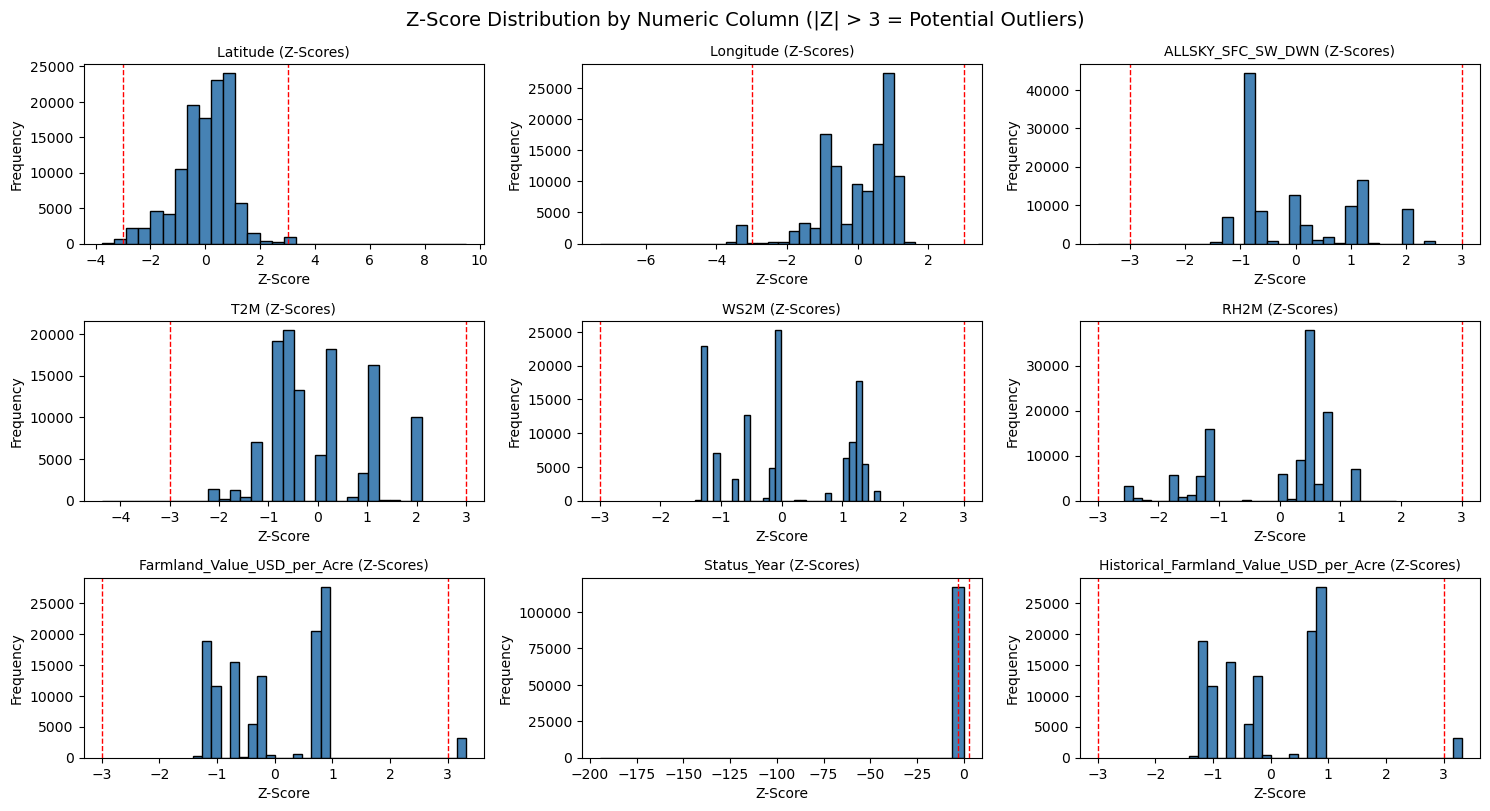


Potential Outliers (|Z| > 3):

Longitude                                 3363
Farmland_Value_USD_per_Acre               3262
Historical_Farmland_Value_USD_per_Acre    3262
Latitude                                  1069
Status_Year                                 21
ALLSKY_SFC_SW_DWN                           12
T2M                                         12
WS2M                                         0
RH2M                                         0
dtype: int64


In [11]:
#---------------------------
# From observing the dataset, duplicates were quite evident.
#---------------------------
df[df.duplicated(keep=False)]
print('Duplicate values taken care of.')

#---------------------------
# To identify missing values, the average was taken for each respective column variable with NaN values.
#---------------------------
nan_type = df['Type'].isnull().sum() / len(df['Type']) * 100
nan_status = df['Status'].isnull().sum() / len(df['Status']) * 100

geo_cols = ['County', 'State', 'ALLSKY_SFC_SW_DWN', 'T2M', 'WS2M', 'RH2M',
            'Farmland_Value_USD_per_Acre', 'Historical_Farmland_Value_USD_per_Acre']
class_cols = ['Latitude', 'Longitude', 'Well identifier']
nan_geography = df[geo_cols].isnull().mean().mean() * 100
nan_classification = df[class_cols].isnull().mean().mean() * 100

print('Average (%) "NaN" values for column varable "Type":', nan_type, '\nAverage (%) "NaN" values for column varable "Status":', nan_status, '\nAverage (%) "NaN" values for column varables dealing with geography and cost:', nan_geography, '\nAverage (%) "NaN" values for column varables dealing with classification:', nan_classification)

#---------------------------
# Ensuring, at least, my raw data are not 3 standard deviations above my mean.
# However, even though outliers are plausible within the coordinate and financial data, it might not be erroneous.
#---------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
z_df = pd.DataFrame(index=df.index)
for col in numeric_cols:
    col_data = df[col]
    if col_data.isna().all() or col_data.std(skipna=True) == 0:
        continue
    z_col = (col_data - col_data.mean(skipna=True)) / col_data.std(skipna=True)
    z_df[col] = z_col

valid_cols = z_df.columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(valid_cols, 1):
    plt.subplot(len(valid_cols) // 3 + 1, 3, i)
    col_data = z_df[col].dropna()
    if col_data.empty:
        continue
    plt.hist(col_data, bins=30, color='steelblue', edgecolor='black')
    plt.title(f"{col} (Z-Scores)", fontsize=10)
    plt.axvline(3, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(-3, color='red', linestyle='dashed', linewidth=1)
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle("Z-Score Distribution by Numeric Column (|Z| > 3 = Potential Outliers)", fontsize=14, y=1.02)
plt.show()

# -----------------------
# With z-scores for outlier values printed per columnm, it is now necessary to find the count for these outliers
# -----------------------
outlier_counts = (np.abs(z_df) > 3).sum()
print("\nPotential Outliers (|Z| > 3):\n")
print(outlier_counts.sort_values(ascending=False))



#*Handling Potential Issues / Detailed Plan*

The duplicates within the dataset were removed. Although there are minute distinctions between some duplicate rows, it is unnecessary to be microscopically sensitive to variances within any duplicate cell, in any respective column for this dataset. Capitalization and abbreviation issues will be handled by replacing any lower-case string (object) values with capitalized values. There are quite a bit of column variables with missing values. For 'Type' and 'Status', these missing values will be replaced with 'UNKNOWN' and 'UNSPECIFIED', respectively. For 'County' and 'State', these missing values will remain obviated, as column variables 'latitude' and 'longitude' suffice.
To preserve distribution, missing values for 'Farmland_Value_USD_per_Acre' and 'Historical_Farmland_Value_USD_per_Acre' will be replaced with the median. The mode value for 'Land_Value_Year' and 'Status_Year', respectively, will replace any of their missing values. This cleaned dataset will be saved to Google Drive.

For handling outliers, if all latitude and longitude data are within the U.S., the values will remain in the dataset. Throughout the data exploration phase, financial outliers will be explored. 'Status Year' outlier data will remain becuase newer status data, e.g. 2018, may indicate a new reserve identification or drilling technique updates. Environmental outlier data will remain because it may assist in painting a more accurate picture with weather data (will be corroborated in the data exploration phase).

is_in_us
True     117396
False       282
Name: count, dtype: int64


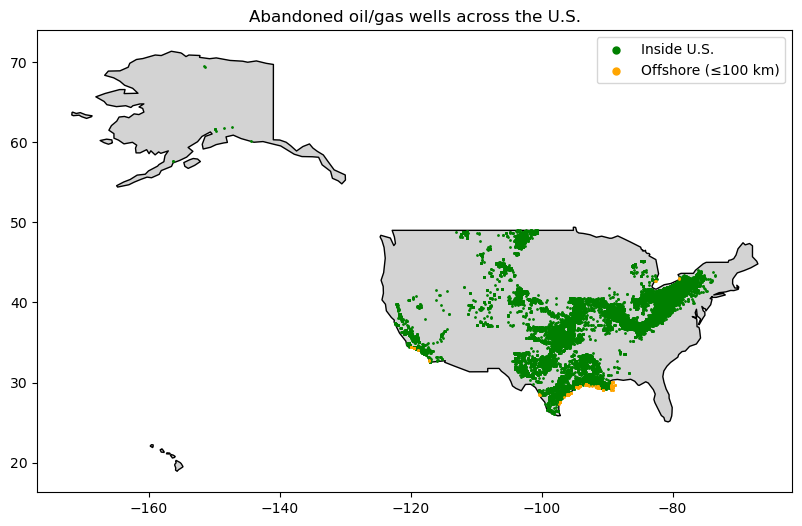

In [ ]:
# -----------------------
# In the code block below, all coordinate data are vetted to ensure they exist within the U.S.
# -----------------------
geometry = gpd.points_from_xy(df['Longitude'], df['Latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

us_boundary_path = r"C:\Users\bzwil\OneDrive\Desktop\ABWELLS\data\USA.geo (1).json" 
us_boundary = gpd.read_file(us_boundary_path)

points_with_country = gpd.sjoin(gdf, us_boundary, how="left", predicate="within")
gdf['is_in_us'] = points_with_country['index_right'].notna()

us_projected = us_boundary.to_crs(epsg=5070)
us_buffer_m = us_projected.buffer(100_000)

# -----------------------
# In case any wells are on U.S. islands
# -----------------------
us_buffer = gpd.GeoDataFrame(geometry=us_buffer_m, crs=us_projected.crs).to_crs(gdf.crs)
points_with_buffer = gpd.sjoin(
    gdf, us_buffer, how="left", predicate="within"
)
gdf["is_in_buffer"] = points_with_buffer["index_right"].notna()
gdf["is_offshore"] = gdf["is_in_buffer"] & ~gdf["is_in_us"]
print(gdf['is_in_us'].value_counts())

# -----------------------
# Plotting the data
# -----------------------
ax = us_boundary.plot(color="lightgray", edgecolor="black", figsize=(10, 6))

# -----------------------
# inside U.S. boundary
# -----------------------
inside = gdf[gdf["is_in_us"] & gdf.geometry.notna()]
inside.plot(ax=ax, color="green", markersize=1, label="Inside U.S.")

# -----------------------
# offshore U.S. boundary (not beyond 100 km)
# -----------------------
offshore = gdf[gdf["is_offshore"] & gdf.geometry.notna()]
offshore.plot(ax=ax, color="orange", markersize=1, label="Offshore (≤100 km)")

ax.set_title('Abandoned oil/gas wells across the U.S.')

ax.legend(markerscale=5)

# -----------------------
# Since my coordinate data are still within 100 km of the U.S., I will keep the outliers.
# -----------------------

In [ ]:
#---------------------------
# The duplicate rows with minimal distinctions will be removed. For the coordinate distinctions in the duplicate rows, they vary by at most 0.0002. For the 'CLINTON' County duplicates, there are two Water Injection and Oil wells each. 1 of each will be removed.
#---------------------------
dupe_ids = df[df.duplicated(subset=['Well identifier'], keep=False)]
summary = dupe_ids.groupby('Well identifier').agg({
    'County': pd.Series.unique,
    'Type': pd.Series.unique,
    'Status': pd.Series.unique,
    'Latitude': ['min', 'max'],
    'Longitude': ['min', 'max']
})
print(summary)

#---------------------------
# There is an issue of inconsistent capitalization and abbreviations.
#---------------------------
type_corrections = {
    'O': 'OIL',
    'WI': 'WATER INJECTION',
    'SWD': 'SALT WATER DISPOSAL',
    'CM': 'COAL MINE',
    'EOR': 'ENHANCED OIL RECOVERY',
    'WS': 'WATER SOURCE',
    'EXP': 'EXPLORATORY',
    'DRY GAS': 'GAS',
    'OIL & GAS': 'OIL AND GAS'
}

status_corrections = {
    'P&A': 'PLUGGED AND ABANDONED',
    'AB': 'ABANDONED',
    'PA': 'PLUGGED AND ABANDONED',
    'SI': 'SHUT-IN',
    'SUSP': 'SUSPENDED',
    'UNSPECIFIED': 'UNSPECIFIED/OTHER'
}
df['Status'] = df['Status'].replace(status_corrections)
df['Type'] = df['Type'].replace(type_corrections)
df['Status'] = df['Status'].str.upper().str.strip()
df['County'] = df['County'].str.title().str.strip()

#---------------------------
# Mainly within the column variable 'Type' there are missing values. The code below handles all missing and misspelled values.
# Instead of obviating the missing values' cells from 'Type' and 'Status', replacing the NaN values with 'UNKNOWN' and 'UNSPECIFIED', respectively, will work.
# For 'County' and 'State', the plan is to keep these as NaN, as having lat and long data suffices.
# For the financial data, the missing values will be replaced with median to preserve distribution.
# For 'Land_Value_Year' and 'Status_Year', their NaN values will be replaced with the most common year (mode)
#---------------------------
drop = df.isnull().sum().sort_values(ascending=False)
df['Type'] = df['Type'].fillna('UNKNOWN')
df['Status'] = df['Status'].fillna('UNSPECIFIED')
for col in ['Farmland_Value_USD_per_Acre',
            'Historical_Farmland_Value_USD_per_Acre']:
    df[col].fillna(df[col].median(), inplace=True)
df['Land_Value_Year'].fillna(df['Land_Value_Year'].mode()[0], inplace=True)
df['Status_Year'].fillna(df['Status_Year'].mode()[0], inplace=True)

# -----------------------
# Here is the dataset post-changes.
# -----------------------
df.to_csv(r"C:\Users\bzwil\OneDrive\Desktop\ABWELLS\data\wells_postchanges.csv", index=False)
print("Head of Dataset After Cleaning:\n", df.head(), "\nTail of Dataset After Cleaning:\n", df.tail())


                       County                Type      Status   Latitude  \
                       unique              unique      unique        min   
Well identifier                                                            
API:12027026460000  [CLINTON]             [O, WI]    [Orphan]  38.563683   
API:12027026490000  [CLINTON]             [O, WI]    [Orphan]  38.569017   
API:24037202200000     [Cass]  [Gas(Private Use)]  [Orphaned]  38.822680   

                               Longitude             
                          max        min        max  
Well identifier                                      
API:12027026460000  38.563817 -89.170883 -89.170867  
API:12027026490000  38.569017 -89.168633 -89.168467  
API:24037202200000  38.822680 -94.576210 -94.576210  


C:\Users\bzwil\AppData\Local\Temp\ipykernel_34912\1940893101.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\bzwil\AppData\Local\Temp\ipykernel_34912\1940893101.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Head of Dataset After Cleaning:
       Well identifier     County Type     Status   Latitude  Longitude  \
0  API:01023198330000    Choctaw  OIL  ABANDONED  31.870633 -88.262407   
1  API:01023199710000    Choctaw  OIL  ABANDONED  31.868743 -88.243366   
2  API:01023199850000    Choctaw  OIL  ABANDONED  31.882103 -88.423896   
3  API:01039200300000  Covington  OIL  ABANDONED  31.179635 -86.592117   
4  API:01039200310000  Covington  OIL  ABANDONED  31.179795 -86.589197   

     State  ALLSKY_SFC_SW_DWN        T2M      WS2M       RH2M  \
0  ALABAMA          17.282548  17.353699  0.186712  75.960329   
1  ALABAMA          17.282548  17.353699  0.186712  75.960329   
2  ALABAMA          17.282548  17.353699  0.186712  75.960329   
3  ALABAMA          17.282548  17.353699  0.186712  75.960329   
4  ALABAMA          17.282548  17.353699  0.186712  75.960329   

   Farmland_Value_USD_per_Acre  Land_Value_Year  Status_Year  \
0                       4040.0           2022.0       1974.0   
1  

#*Reorganization Needs*

There are no reorganization needs. The current column order and names, post changes, of the dataset are cogent.

#*Initial Thoughts*

Given the data acquired, currently, there is sufficient information to answer the hypothesis. This optimism stems from the diversity of environmental and location data within the dataset. However, the statistical confidence could increase if usable 'total acres' data was available.  





#*Characteristics of the Data*

All characteristics of the data can be found in the preliminary information cell block.


#*Logarithm Transform Needs*

For 'WS2M' (wind speed at 2 meters above ground), the mean is '1.865921', while the max is '3.903288', evident in the preliminary information cell block (where all summary statistics are). The variance for this column is too high, so descaling is necessary.

The 'Farmland_Value_USD_per_acre' has a diverse set of data with a wide parameter range as well. Descaling this is also necessary.

Both variables are right-skewed.

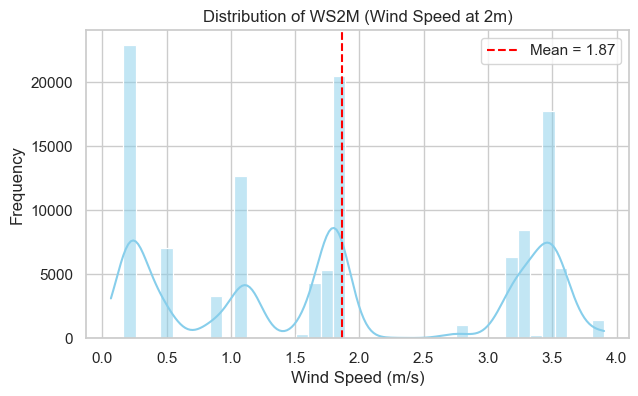

In [14]:
# -----------------------
# Evidence of the high variance within 'WS2M'.
# -----------------------
sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(7,4))
sns.histplot(df["WS2M"], kde=True, bins=40, color='skyblue')
plt.title("Distribution of WS2M (Wind Speed at 2m)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.axvline(df["WS2M"].mean(), color='red', linestyle='--', label=f"Mean = {df["WS2M"].mean():.2f}")
plt.legend()
plt.show()


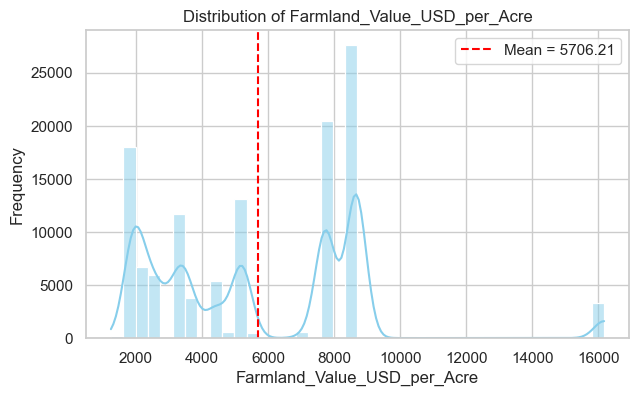

In [15]:
# -----------------------
# Evidence of the high variance within 'Farmland_Value_USD_per_acre'.
# -----------------------
sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(7,4))
sns.histplot(df["Farmland_Value_USD_per_Acre"], kde=True, bins=40, color='skyblue')
plt.title("Distribution of Farmland_Value_USD_per_Acre")
plt.xlabel("Farmland_Value_USD_per_Acre")
plt.ylabel("Frequency")
plt.axvline(df["Farmland_Value_USD_per_Acre"].mean(), color='red', linestyle='--', label=f"Mean = {df["Farmland_Value_USD_per_Acre"].mean():.2f}")
plt.legend()
plt.show()


#*Transformations/Manipulations*

Units:

'WS2M' - meters per second (2 meters above the ground)

'ALLSKY_SFC_SW_DWN' - megajoules per square meter per day

T2M - degrees Celsius (2 meters above the ground)

RH2M - water vapor content / saturation (2 meters above the ground)


Every variable's datatype are provided in the 'Preliminary Information' cell

----------------------------------------

1.) Given that there are issues for variable 'WS2M' (wind-speed at 2 meters above the ground). The right skewed data, evident in the maximum value being around 3.9 m/s, while the mean is 1.86 m/s, will be descaled via logarithm transform.

2.) The 'Farmland_Value_USD_per_acre' has high variance due to the price differences in counties across the states. Because of this, a logarithm transform would be ideal here too. This will also handle its outliers, as removing isn't logical due to its indispensability in the dataset.

3.) I have also ran into an issue regarding coordinate projections. For the 'Latitude' and 'Longitude' data, EPSG:4326 preserves the shape of the Earth for its coordinate system. Foreseeably, this would create issues for accurately plotting spatial maps. Therefore, the coordinate data will be reprojected to EPSG:5070.    

In [ ]:
# -----------------------
# Applying transformations and revisions
# -----------------------
# 1. and 2.)
df["WS2M"] = df["WS2M"].replace(0, np.nan)
df["Farmland_Value_USD_per_Acre"] = df["Farmland_Value_USD_per_Acre"].replace(0, np.nan)
df["Historical_Farmland_Value_USD_per_Acre"] = df["Historical_Farmland_Value_USD_per_Acre"].replace(0, np.nan)

df['WS2M_log'] = np.log(df['WS2M'] + 1)
df['Farmland_Value_USD_per_Acre_log'] = np.log(df['Farmland_Value_USD_per_Acre'])
df["Historical_Farmland_Value_log"] = np.log(df["Historical_Farmland_Value_USD_per_Acre"])

# 3.)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

gdf_5070 = gdf.to_crs(epsg=5070)
gdf_5070["X_meters"] = gdf_5070.geometry.x
gdf_5070["Y_meters"] = gdf_5070.geometry.y

print(gdf_5070.columns.tolist())

# -----------------------
# creating new GEOJSON and CSV
# -----------------------
cols_to_keep = [
    "Well identifier", "State", "County", "Type", "Status",
    "WS2M", "WS2M_log", "RH2M", "T2M", "ALLSKY_SFC_SW_DWN",
    "Farmland_Value_USD_per_Acre", "Farmland_Value_USD_per_Acre_log",
    "Historical_Farmland_Value_USD_per_Acre", "Historical_Farmland_Value_log",
    "Latitude", "Longitude", "X_meters", "Y_meters", "geometry"
]

clean_gdf = gdf_5070[cols_to_keep].copy()

clean_gdf.to_file("wells_transformed_5070_1.geojson", driver="GeoJSON")
clean_gdf.to_csv(r"C:\Users\bzwil\OneDrive\Desktop\ABWELLS\data\wells_transformed_5070_1.csv", index=False)


['Well identifier', 'County', 'Type', 'Status', 'Latitude', 'Longitude', 'State', 'ALLSKY_SFC_SW_DWN', 'T2M', 'WS2M', 'RH2M', 'Farmland_Value_USD_per_Acre', 'Land_Value_Year', 'Status_Year', 'Historical_Farmland_Value_USD_per_Acre', 'WS2M_log', 'Farmland_Value_USD_per_Acre_log', 'Historical_Farmland_Value_log', 'geometry', 'X_meters', 'Y_meters']


#*Exteme Outliers or Missing Data*

Now that all data revisions have been addressed. It is necessary to sufficiently check for any missing data or extreme outliers.

In [17]:
# --------------------
# Basic Missing Data Check
# --------------------
missing_summary = (
    clean_gdf
    .isna()
    .sum()
    .to_frame(name="Missing_Count")
)

missing_summary["Missing_Percent"] = (
    missing_summary["Missing_Count"] / len(clean_gdf) * 100
)

missing_summary.sort_values("Missing_Count", ascending=False)

,Missing_Count,Missing_Percent
County,467,0.396846
ALLSKY_SFC_SW_DWN,355,0.301671
WS2M,355,0.301671
WS2M_log,355,0.301671
RH2M,355,0.301671
T2M,355,0.301671
State,355,0.301671
Historical_Farmland_Value_log,0,0.000000
Y_meters,0,0.000000
X_meters,0,0.000000


#*Handling Missing Values*

For handling these missing values depicted above, proper splits by variable type will be conducted. For environmental data, a median imputation will sufficiently work. For log-transformed values, they will be recomputed after imputation. For categorical values, 'Unknown' values will be input.  

In [18]:
# --------------------
# Handle missing categorical variables
# --------------------
categorical_cols = ["State", "County"]

for col in categorical_cols:
    clean_gdf[col] = clean_gdf[col].fillna("Unknown")

In [19]:
# --------------------
# Median imputation for environmental variables
# --------------------
env_cols = [
    "WS2M",
    "ALLSKY_SFC_SW_DWN",
    "T2M",
    "RH2M"
]

imputer = SimpleImputer(strategy="median")

clean_gdf[env_cols] = imputer.fit_transform(clean_gdf[env_cols])

In [20]:
# --------------------
# Recompute log variables after imputation
# --------------------
clean_gdf["WS2M_log"] = np.log1p(clean_gdf["WS2M"])
clean_gdf["Farmland_Value_USD_per_Acre_log"] = np.log1p(
    clean_gdf["Farmland_Value_USD_per_Acre"]
)
clean_gdf["Historical_Farmland_Value_log"] = np.log1p(
    clean_gdf["Historical_Farmland_Value_USD_per_Acre"]
)

In [21]:
# --------------------
# Verifying missing values have been resolved
# --------------------
clean_gdf.isna().sum()

Well identifier                           0
State                                     0
County                                    0
Type                                      0
Status                                    0
WS2M                                      0
WS2M_log                                  0
RH2M                                      0
T2M                                       0
ALLSKY_SFC_SW_DWN                         0
Farmland_Value_USD_per_Acre               0
Farmland_Value_USD_per_Acre_log           0
Historical_Farmland_Value_USD_per_Acre    0
Historical_Farmland_Value_log             0
Latitude                                  0
Longitude                                 0
X_meters                                  0
Y_meters                                  0
geometry                                  0
dtype: int64

#*Value Representation*

Now that new variables have been added to the dataset, an overview of each variable within the dataset will assist in contextual interpretation later when predictions are calculated.

'Well identifier' - Unique identifier assigned to each oil or gas well observation.

'State' - U.S. state in which the well is located.

'County' - County-level geographic designation of the well’s location.

'Type' - Classification of the well (e.g., oil, gas, injection).

'Status' - Operational status of the well (e.g., active, orphaned, inactive).

'WS2M' - Average wind speed measured at 2 meters above the surface (meters per second), representing near-surface atmospheric conditions.

'WS2M_log' - Log-transformed wind speed, used to reduce skewness and stabilize variance for modeling.

'RH2M' - Relative humidity at 2 meters above the surface (percentage), representing near-surface moisture conditions.

'T2M' - Air temperature at 2 meters above the surface (degrees Celsius), capturing local climatic conditions.

'ALLSKY_SFC_SW_DWN' - All-sky surface shortwave downward solar irradiance (megajoules per square meter per day), representing the amount of solar energy reaching the ground.

'Farmland_Value_USD_per_Acre_log' - Log-transformed farmland value (Market value of farmland in U.S. dollars per acre for the given location.), used to normalize the distribution and reduce the influence of extreme values.

'Historical_Farmland_Value_log' - Log-transformed historical farmland value (Historical farmland value (USD per acre), capturing long-term economic trends and persistence in land valuation.), used for scale normalization and modeling stability.

'Latitude' - Geographic latitude of the well location (decimal degrees).

'Longitude' - Geographic longitude of the well location (decimal degrees).

#*Relationships between variables*

Throughout this next section, variable relationship will be explored.

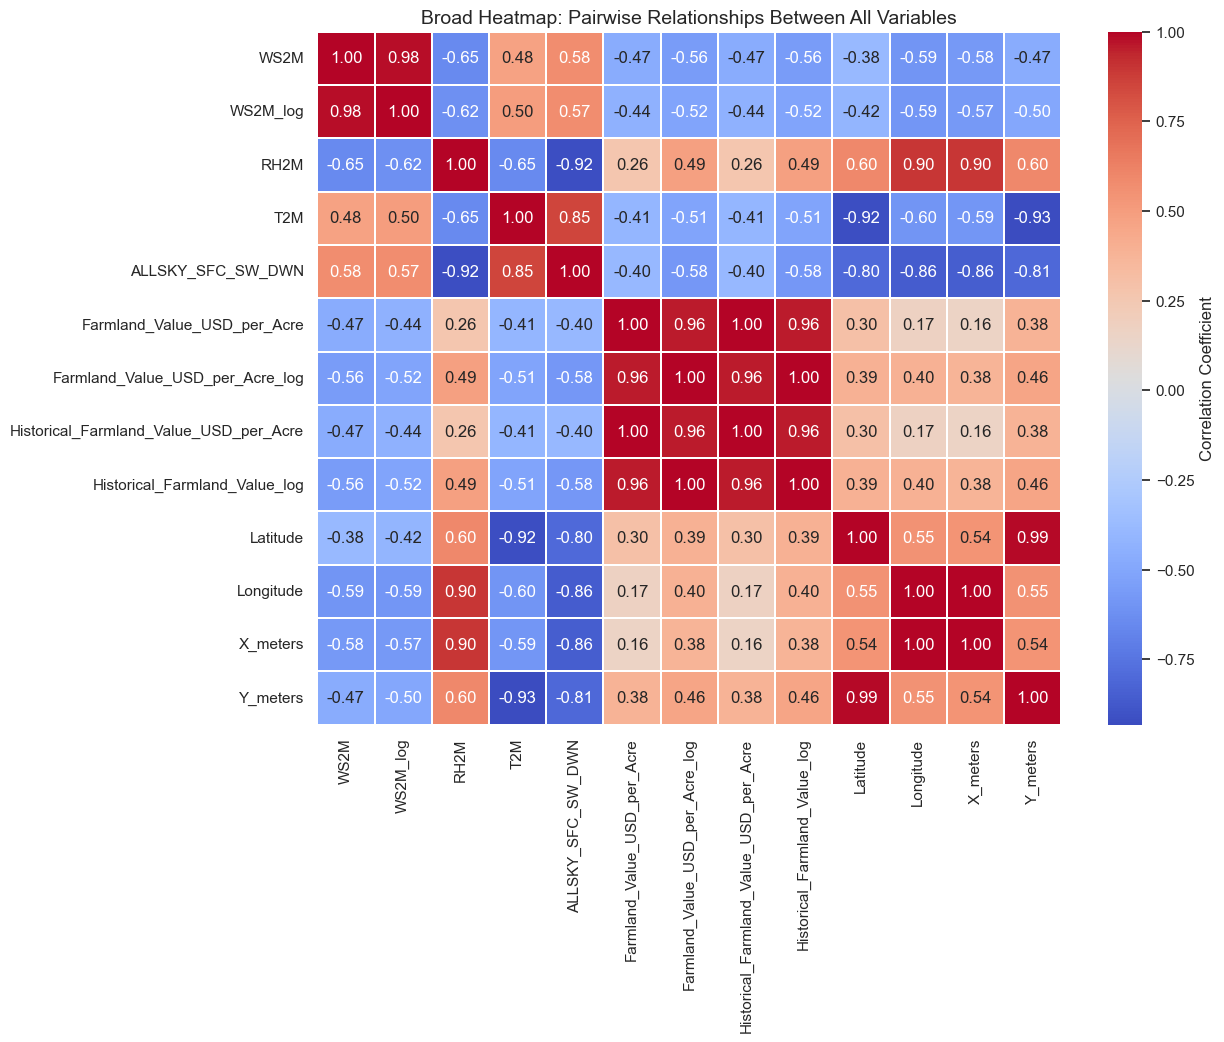

In [22]:
# -----------------------
# Broad heatmap for variable correlation
# -----------------------

numeric_cols = clean_gdf.select_dtypes(include=[np.number]).columns

corr_matrix = clean_gdf[numeric_cols].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "Correlation Coefficient"}
)
plt.title("Broad Heatmap: Pairwise Relationships Between All Variables", fontsize=14)
plt.show()

# -----------------------
# As expected, 'Historical_Farmland_Value_USD_per_Acre' forms a strong positive relationship with 'Farmland_Value_USD_per_Acre', meaning as time progress, it's expected for land valuation to progress contextually with its respective historical value.
# Already, there are data points not supporting the hypothesis. For instance, 'WS2M' shows weak correlation with 'Farmland_Value_USD_per_Acre', contradicting the introductory clause: 'If ..., wind speed, ... are significant predictors of land value'.
# -----------------------

#*Plot Interpretation*

As expected, 'Historical_Farmland_Value_USD_per_Acre' forms a strong positive relationship with 'Farmland_Value_USD_per_Acre', meaning as time progress, it's expected for land valuation to increase contextually with its respective historical value. Already, there are data points not supporting the hypothesis. For instance, 'WS2M' shows weak correlation with 'Farmland_Value_USD_per_Acre', contradicting the introductory clause of the hypothesis: 'If ..., wind speed, ... are significant predictors of land value...'  

C:\Users\bzwil\AppData\Local\Temp\ipykernel_34912\3496065225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Type", y="ALLSKY_SFC_SW_DWN", data=oil_gas_df, palette=["goldenrod", "steelblue"])


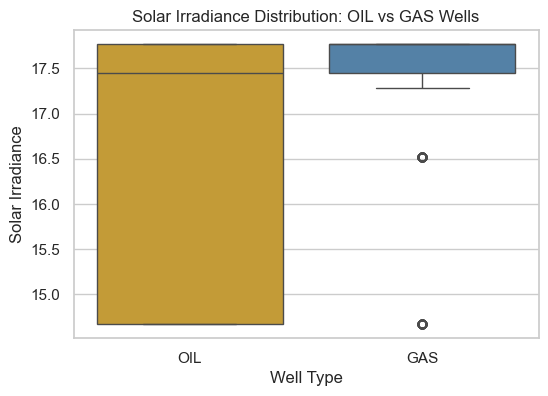

In [23]:
# -----------------------
# It will be useful for future analysis to plot 'Type' against 'ALLSKY_SFC_SW_DWN'. This will assist in prioritizing land plots that could plausibly have higher projected post-restoration land values (USD per acre)
# -----------------------
oil_gas_df = clean_gdf[df["Type"].isin(["OIL", "GAS"])]

plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="ALLSKY_SFC_SW_DWN", data=oil_gas_df, palette=["goldenrod", "steelblue"])
plt.title("Solar Irradiance Distribution: OIL vs GAS Wells")
plt.xlabel("Well Type")
plt.ylabel("Solar Irradiance")
plt.show()

#*Plot Interpretation*

Given the quartile range for the subset data within 'Type', 'GAS', is narrower than 'OIL' and that it's data is left-skewed, this suggests 'GAS' data are located in consistently sunnier regions, more suitable for renewable-energy redevelopment or post-restoration agricultural recovery.

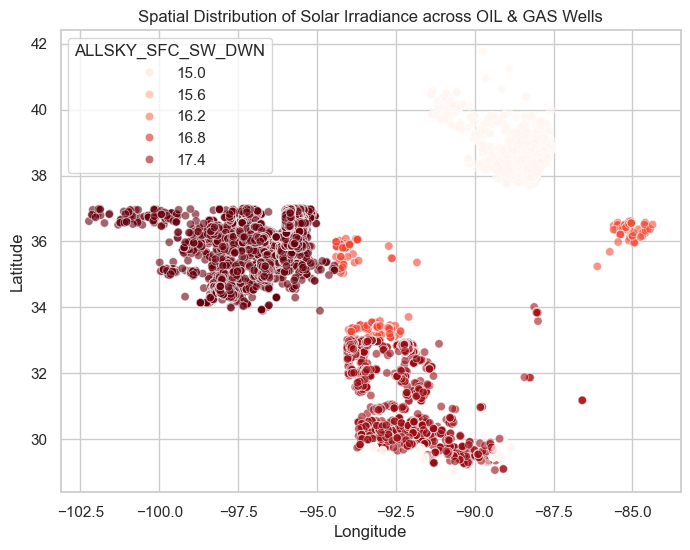

In [24]:
# -----------------------
# Geospatially plotting GAS wells over solar irradiance
# -----------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=oil_gas_df, x="Longitude", y="Latitude",
    hue="ALLSKY_SFC_SW_DWN", palette="Reds", alpha=0.6
)
plt.title("Spatial Distribution of Solar Irradiance across OIL & GAS Wells")
plt.show()

#*Plot Interpretation*

'GAS' wells receiving high solar irradiance do cluster and this plot confirms it. According to the coordinates, the cluster covers central Oklahoma, northern Texas, and parts of western Arkansas. This information is imperative for focalizing the data analysis.

#*Question of Trust*
This dataset is trustworthy to use because, primarily, the data cleaning requirements were minor and there are plenty variety amongst the environmental variables. Although it seems that all environmental variables won't be necessary to use in the data analysis phase, the paramount one, 'ALLSKY_SFC_SW_DWN', contributes to the auspiciousness of the hypothesis.

In the next phase, the regional coordinates indicated in the text block above will be analyzed for hypothesis support (likely to be the sample space).

#*ML Task*

This is a supervised-learning, regression task, as the goal is to predict post-restoration land values based upon, primarily, solar irradiance, historic land value, and current land value, with covariables including wind speed, temperature, location, and relative humidity.



#*Features*

Primary Features
- Solar Irradiance (ALLSKY_SFC_SW_DWN) → continuous

- Historic Land Value → continuous

- Current Land Value → continuous

Because the hypothesis is predicting post-restoration land value, prioritizing valuation trends and radiation data will significantly impact the predicted value result. These features explain the paramount environmental feature and economic patterns, which is why they were selected.  

Secondary Features
- Location (State & County) → categorical

- Wind Speed (WS2M) → continuous

- Relative Humidity (RH2M) → continuous

- Temperature (T2M) → continuous

These secondary features provide necessary context for describing each abaondoned oil/gas well. In addition to location data, these other environmental variables entail climate information, imperative for a wholistic picture, which is why they were selected.

#*Data Revision*

Unneccesary variables for the ML model include 'Well identifier', 'Status_Year', 'Land_Value_Year', 'Latitude', 'Longitude', 'Farmland_Value_USD_per_Acre_log' and 'Historical_Farmland_Value_log. These will be removed from the dataset.

Location data will be converted to binary vectors via one-hot encoding.

#*Potential Benefits/Caveats*

Because of the variable attempting to be predicted (post-restoration land value) and the size of the dataset, all features are important for the model. Dimensions can be reduced, however, and could improve accuracy, if too many observations are being computed with diminished accuracy.

The downside is considered if too few features are evaluated, this could result in inaccuracy due to underfitting.  

In [ ]:
# -----------------------
# Constraining the location data to the area of interest indicated above
# -----------------------
lat_min, lat_max = 30, 42
lon_min, lon_max = -102.5, -85

df = clean_gdf[
    (clean_gdf["Latitude"] >= lat_min) &
    (clean_gdf["Latitude"] <= lat_max) &
    (clean_gdf["Longitude"] >= lon_min) &
    (clean_gdf["Longitude"] <= lon_max)
].copy()

# -----------------------
# Removing unneccesary data columns
# -----------------------
df.drop(columns=['Well identifier', 'Latitude', 'Longitude', 'Farmland_Value_USD_per_Acre_log', 'Historical_Farmland_Value_log'], inplace=True)

# -----------------------
# One-hot encoding 'State' and 'County'
# -----------------------
cat_cols = ['State', 'County', 'Type', 'Status']
df_encoded = pd.get_dummies(clean_gdf, columns=cat_cols, drop_first=True)

# -----------------------
# Converting 'State' and 'County' to numeric
# -----------------------
bool_cols = df.select_dtypes(include="bool").columns
df[bool_cols] = df[bool_cols].astype(int)


df_encoded.to_csv(r"C:\Users\bzwil\OneDrive\Desktop\ABWELLS\data\wells_encoded_1.csv", index=False)
print(df_encoded.head)

# -----------------------
# Because of the location encoding, this dataset has increased in size by 502 columns.
# -----------------------

<bound method NDFrame.head of            Well identifier      WS2M  WS2M_log       RH2M        T2M  \
0       API:01023198330000  0.186712  0.171187  75.960329  17.353699   
1       API:01023199710000  0.186712  0.171187  75.960329  17.353699   
2       API:01023199850000  0.186712  0.171187  75.960329  17.353699   
3       API:01039200300000  0.186712  0.171187  75.960329  17.353699   
4       API:01039200310000  0.186712  0.171187  75.960329  17.353699   
...                    ...       ...       ...        ...        ...   
117673  API:49045220900000  3.518274  1.508130  55.740274   6.412192   
117674  API:49045226890000  3.518274  1.508130  55.740274   6.412192   
117675  API:49045292750000  3.518274  1.508130  55.740274   6.412192   
117676  API:49045292820000  3.518274  1.508130  55.740274   6.412192   
117677  API:49045601710000  3.518274  1.508130  55.740274   6.412192   

        ALLSKY_SFC_SW_DWN  Farmland_Value_USD_per_Acre  \
0               17.282548                      

#*Assumptions*

Independence can be assumed because each row represents a different well at a different location. Wells are not time series, and no two wells directly "influence" one another.

#*Proposed Algorithm*

Based upon the correlation matrix calculated above, Random Forrest Regression may be the best model to use, given the potential multicollinearity (between historic and current land value) and continuous climate variables.

Random Forrest Regression does not assume any specific distribution. However, extreme outliers can impact feature importance calculations, that is why a logarithm transform was applied to skewed variables, i.e. wind speed. The larger and more focalized the dataset is, the better.

Issues can arise with the dataset if tree nodes get too deep. In the case where the model continues to iterate through a branch, unneccesarily, spurious conclusions can be made, leading to overfitting.

#*Hyperparameters To Tune*

'n_estimators' - This parameter will be tuned to ensure a robust enough model is utilized without too long of a training time. Because of the size of the dataset, ~300 estimators will be set first.

'max_depth' - This will be tuned to optimize model learning, ideally avoiding memorizing or over complexity. Because the goal is to still capture all relationships between variables while minimizing overfitting, the depth will be set to 15.

'min_samples_split' - This will be tuned to stabilize splits. To start, this parameter will be set to 5. (Subject to change if purity is effected.)

'min_samples_leaf' - This will be tuned to prevent extreme samples, where one used is over considered. That is why this paramter will be set to 2.  

'max_features' - This will be tuned to reduce correlation between trees. To prevent redudancy or high similarity, the max features will be square rooted.

'bootstrap' - This will be tuned to vet the quality of the model. To reduce variance with the prediction, the boolean value will be set to true.

#*Post-Processing*

Residual checking (actual - predicted) and feature importance extraction will be computed to calculate error and view which variables matter most.

In [26]:
# --------------------
# Defining the target variable and features
# --------------------

# Target
y = df_encoded["Farmland_Value_USD_per_Acre"]

# Features
X = df_encoded.drop(columns=["Farmland_Value_USD_per_Acre", "Well identifier", "geometry"])


In [27]:
# --------------------
# Distributing the data properly
# --------------------
# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
# --------------------
# Training the model
# --------------------
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Fit model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, random_state=42)

In [29]:
# --------------------
# Computing predictions and measuring accuracy
# --------------------
# Predictions
y_pred = rf_model.predict(X_test)

# Accuracy score
accuracy = r2_score(y_test, y_pred)

print("Random Forest Regression R² Score:", accuracy)


Random Forest Regression R² Score: 0.9994125359778444


In [30]:
# --------------------
# Viewing the most influential features
# --------------------
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 15 Feature Importances:")
for i in range(15):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]}")


Top 15 Feature Importances:
Historical_Farmland_Value_log: 0.11975138704418195
Historical_Farmland_Value_USD_per_Acre: 0.11319419898790349
Farmland_Value_USD_per_Acre_log: 0.09968119718644057
T2M: 0.06352573590695765
Longitude: 0.05832139230799054
RH2M: 0.05325673925945719
State_CALIFORNIA: 0.04786188811591264
WS2M_log: 0.046828125477096236
WS2M: 0.043679796054948594
X_meters: 0.04142947373941974
ALLSKY_SFC_SW_DWN: 0.040723285591048916
Y_meters: 0.028807349311771105
Latitude: 0.02560358890305576
Type_Oil & Gas: 0.02262211099241396
Status_IDLE: 0.018198800680275903


#*Evaluation*

Because this project focuses on predicting a continuous numeric outcome, post-restoration land value, the goal is not simply to minimize error on individual observations, but to understand how well the model explains variation in the target variable across the dataset as a whole. For this reason, R² is the optimal metric for effectively measuring the performance of this regression model.

It is necessary to compare these metrics across models to corroborate if the random forest regression model reflects real signal in the data and not accidental alignment between the model and the data. To do this, models will be trained and tested on the dataset, cross-validation (5-fold) will be performed for each model to reduce bias, and finally, a box-plot comparison of all models will be plotted.

All models will use the same train/test split to have a direct, controlled comparison of model performance.


In [31]:
# -----------------------
# Same split for all - match original model
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
# -----------------------
# Define CV strategy
# -----------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# -----------------------
# Cross validating the original mdoel first
# -----------------------
# Cross-validated R² for Random Forest Regression model
rf_scores = cross_val_score(
    rf_model, X, y,
    cv=cv,
    scoring="r2"
)

#*Model #1: Gradient Boosting Regressor*

Comparing my original model with a Gradient Boosting Regressor could be informative on how the signal behaves. It could be assumed that if the signal is complex, this model will perform better because it iteratively processes and corrects error.  

In [34]:
# -----------------------
# Train the model
# Also added an imputer & pipeline to prevent data leakage
# -----------------------
gbr_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gbr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=300,
                                           random_state=42))])

In [35]:
# -----------------------
# Cross-validated R² for Model 1
# -----------------------
gbr_scores = cross_val_score(
    gbr_pipeline, X, y,
    cv=cv,
    scoring="r2"
)

#*Model #2: Elastic Net Regresson*

Even though this model will plausibly decrease performance, as it forces a linear structure and penalizes feature complexity, it will assist in explaining whether or not the hypothesis could still be significantly supported without nonlinear interactions and hierarchial splits.

In [36]:
# -----------------------
# Train the model
# -----------------------
enet_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("enet", ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        random_state=42
    ))
])

In [37]:
# -----------------------
# Calculating cross-validation score
# -----------------------
enet_scores = cross_val_score(
    enet_pipeline, X, y,
    cv=cv,
    scoring="r2"
)

In [38]:
# -----------------------
# Plotting all distributions in comparison
# -----------------------
comparison_df = pd.DataFrame({
    "Random Forest": rf_scores,
    "Gradient Boosting": gbr_scores,
    "Elastic Net": enet_scores
})

comparison_df.describe().T[["mean", "std"]]

,mean,std
Random Forest,0.999241,1.131298e-04
Gradient Boosting,1.000000,9.143747e-09
Elastic Net,0.999991,3.620471e-06


#*Interpretation of Comparison Models' R² scores*

##*Gradient Boosting Regressor*
It seems to be the case that this model compared to others, even though structurally different, as they all test different assumptions, is incredibly accurate. The problem may be easier to solve than it appears. My contributing variables are plausibly mathematically or economically deterministic of the target, 'Farmland_Value_USD_per_Acre'. Logically, it makes sense that this is the case as financial land markets follow economic trends overtime. The error reduction process also significantly contributes to why this model performed the best.

##*Elastic Net Regression*
This result was quite intriguing, as it is informative to how the dominant features impact the predicted value. The strong performance of the model suggests that a small set of predictors carries most of the explanatory signal. In particular, features such as 'ALLSKY_SFC_SW_DWN', 'Historical_Farmland_Value_USD_per_Acre', 'State_ILLINOIS', and 'T2M' appear to contribute substantially to prediction accuracy, indicating that farmland value is largely driven by strong, additive effects rather than complex nonlinear interactions.

#*Fit*

As anticipated, the R² values, after the 5-fold cross validation, are well above 0.999 for each model. This indicates that nearly all variance in farmland value is explained by the feature set. This is neither an issue of overfitting or underfitting, as neither train or test perform significantly better than the other, respectively, for any model. Instead, there is minimal variance across folds, evident in the low standard deviation for each model. There is also minimal bias, as the folds are randomly and repeatedly drawn. Therefore, all models are fitting well.  

#*Testing Tweaks*

As all the models are proving to work in their respective ways, an interesting insight may be to analyze performance as changes are made to algorithms. Each model will be justifiably tweaked to analyze specific parameters.

#*Tweak #1: Early Stopping for Gradient Boosting*

Whether ths model is over-correcting or whether slower learning with more trees yields better generalization, this tweak directly tests the bias/variance balance inside the model.

In [39]:
# -----------------------
# Lower learning_rate and increase n_estimator
# -----------------------
gbr_tuned = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8, # adds randomness
        random_state=42
    ))
])

In [40]:
# -----------------------
# Cross-validated R² for Model 1 after tweak
# -----------------------
gbr_scores2 = cross_val_score(
    gbr_tuned, X, y,
    cv=cv,
    scoring="r2"
)

#*Tweak #2: Regularization Path for Elastic Net Regression*

This test tweaks features to analyze how much specific feature shrinkage is necessary for addressing the hypothesis.  

In [41]:
# -----------------------
# Evaluating multiple alpha values
# -----------------------
alphas = [0.001, 0.01, 0.1, 1.0]

enet_results = {}

for a in alphas:
    enet = ElasticNet(alpha=a, l1_ratio=0.5, random_state=42)
    enet_pipeline2 = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("enet", enet)
    ])

In [42]:
# -----------------------
# Cross-validated R² for Model 2 after tweak
# -----------------------
scores = cross_val_score(enet_pipeline2, X, y, cv=cv, scoring="r2")
enet_results[a] = scores.mean()

In [43]:
# -----------------------
# Plotting all distributions after tweaks
# -----------------------
comparison_df = pd.DataFrame({
    "Random Forest": rf_scores,
    "Gradient Boosting": gbr_scores2,
    "Elastic Net": scores
})

comparison_df.describe().T[["mean", "std"]]

,mean,std
Random Forest,0.999241,1.131298e-04
Gradient Boosting,1.000000,2.289516e-09
Elastic Net,0.999991,3.628752e-06


In [44]:
# -----------------------
# Saving the results
# -----------------------
plt.figure(figsize=(7, 5))

comparison_df.boxplot()
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison_boxplot.png", dpi=300)
plt.close()

#*New Fit*

For Gradient Boosting, the slightly larger standard deviation indicates marginally increased variability across folds, which is expected given the introduction of stochastic elements. However, the variability remains extremely small, indicating excellent generalization and no evidence of overfitting. For Elastic Net Regression, the model continues a strong fit despite its linear constraints, reinforcing the conclusion that the underlying relationships are largely additive and linear in nature. Overall, both models still fit well.

#*Comparison of models, before and after tweaks*

The model tweaks produced no meaningful improvement for the metric of interest, R².


#*Insights*

The results strongly support the hypothesis. Across multiple machine learning regression models, R² values consistently exceeded 0.999, indicating that the selected features explain nearly all observable variance in farmland value. This favors the idea that farmland valuation does not follow an aperiodic trend. Instead, it follows a structured and stable pattern driven by persistent predictors, defined in the features.

One initial assumption was that complex nonlinear models would substaintially outperform simpler or more constrained models. While ensemble methods did achieve the highest R² values, the Elastic Net Regression model also performed exceptionally well. Also, it was assumed that extensive hyperparameter tuning would meaningfully improve performance. In practice, targeted tweaks produced negligible gains, indicating that the original models were already near optimal for this dataset.

The problem is different than originally thought. The problem was approached as a typical regression task where model choice and tuning might significanctly influence outcomes. However, the analysis revealed that the structure of the data itself dominates model performance. This reframed the task to finding out why many models perform similarly well.

Next time, incorporating temporal validation with more data to assess true forecasting ability may be best. Also, exploring spatial cross-validation to account for geographic autocorrelation is important as well, as this would assist in reducing redundancy.

Understanding dominant drivers of land value can guide subsidy allocation, conservation incentives or zoning decisions. Although the primary purpose of this project was to estimate land value for the purpose of land restoration and/or solar farm installation, these decision implications could impact property taxes and/or insurance.

Ethically, these predictive models could reinforce existing economic disparities if used to justify unequal investment. Also, policymakers may defer too heavily to model outputs without considering social or environmental context. This is severly dangerous as the data used does not convey regional, environmental nuances.

Overall, across all five projects, this work emphasized how exploratory analysis, modeling, evaluation, and reflection are deeply interconnected. Most importantly, I learned that strong results require not only technical proficiency, but also critical thinking about data structure, model limitations, and real-world implications.